# Supervised machine learning: Introduction and regularization 
## Binary classification with text data

# Imports

In [2]:
## load packages 
import pandas as pd
import re
import numpy as np
import plotnine
from plotnine import *
import pickle

## nltk imports
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random

pd.set_option('display.max_colwidth', None)

In [3]:
## function to process text
def processtext(one_str, stop_list):
    
    ## remove stopwords
    no_stop = [tok for tok in wordpunct_tokenize(one_str)
              if tok not in stop_list]
    
    
    processed_string = " ".join([porter.stem(i.lower()) 
                        for i in no_stop if 
                        i.lower().isalpha() and len(i) >=3])
    return(processed_string)

## function to create dtm
def create_dtm(list_of_strings, metadata):
    vectorizer = CountVectorizer(lowercase = True)
    dtm_sparse = vectorizer.fit_transform(list_of_strings)
    dtm_dense_named = pd.DataFrame(dtm_sparse.todense(), columns=vectorizer.get_feature_names_out())
    dtm_dense_named_withid = pd.concat([metadata.reset_index(), dtm_dense_named], axis = 1)
    return(dtm_dense_named_withid)

# Load data

Load labeled yelp data in `public_data` and run below code

**Note**: make sure to change your path if you need to; if you're having trouble loading the `pkl`, try running on jupyter hub since it may be a python versioning issue

In [5]:
# If you have trouble loading these data (kernel dies due to memory issues), try sampling down to 5000 or 1000 rows
yelp = pd.read_pickle("../public_data/yelp_forML.pkl") #.sample(n=1000)

In [6]:
## preprocess data to create dtm
porter = PorterStemmer()
list_stopwords = stopwords.words("english")

yelp['process_text'] = [processtext(one_review, stop_list = list_stopwords) 
                        for one_review in yelp['raw_text']]

yelp_dtm = create_dtm(yelp['process_text'], yelp[['metadata_label', 'metadata_rowid',
                                                 'process_text', 'raw_text']])

In [7]:
yelp_dtm

,index,metadata_label,metadata_rowid,process_text,raw_text,aaa,aaaaaa,aaaaaaaaaaaaaaand,aaaaaaaaaaaaahhhhhhhhhhh,aaaaand,...,zoom,zorba,zucchini,zuch,zuchinni,zum,zuma,zumba,zuppa,zwei
0,0,0,0,unfortun frustrat goldberg patient repeat experi mani doctor nyc good doctor terribl staff seem staff simpli never answer phone usual take hour repeat call get answer who time want deal run problem mani doctor get you offic worker patient medic need anyon answer phone incomprehens work aggrav regret feel give goldberg star,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,been go goldberg year think one patient start mhmg great year realli big pictur former gyn markoff found fibroid explor option patient understand judg ask right question veri thorough want kept loop everi aspect medic health life,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,2,know goldberg like move arizona let tell stay away doctor offic go johnson left goldberg took johnson left care doctor interest pay come medic refil everi month give refil could less patient financi situat tri get day mail away pharmaci prescript guy joke and make matter even wors offic staff incompet time call offic put voic mail one ever answer return call both adult children husband decid leav practic experienc frustrat the entir offic attitud like favor give break stay away doc practic you deserv better realli need never felt compel write bad review anyon met pathet excus doctor money,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need them. I have never felt compelled to write a bad review about anyone until I met this pathetic excuse for a doctor who is all about the money.",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,3,write review give head see doctor the offic staff administr unprofession left messag multipl peopl regard bill one ever call back hound get answer bill nsecond import make sure insur go cover goldberg visit blood work recommend get physic knew stud

# 1. Split into features, labels, and split into training/hold out

## 1.1 Split into X (features or id metadata) and y (labels)

In [8]:
X = yelp_dtm[[col for col in yelp_dtm.columns if col not in ['metadata_label',
                                                            'index']]].copy()
y = yelp_dtm[['metadata_label']]

In [9]:
## checking dimensionality
X.shape
y.shape

assert X.shape[0] == y.shape[0]
assert y.shape[1] == 1


(15000, 23439)

(15000, 1)

## 1.2 using automatic function to create train-test split

In [10]:
### using built-in function  
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.2,
                                                   random_state = 221)

## 1.3 using more manual approach to create train-test split

In [12]:
### more manually: useful when we want more control
### over the ids (eg clustering or time ordering)
### or if we want to go back to matrix before preprocessing
nrows_train = round(X.shape[0]*0.8)
nrows_test = X.shape[0] - nrows_train
random.seed(221)
train_ids = random.sample(list(set(X['metadata_rowid'])), nrows_train)

def my_split(X, y, 
             train_ids, 
             id_col):
    
    ## get test ids
    test_ids = set(X[id_col]).difference(train_ids)
    
    ## split
    X_train_man = X[X[id_col].isin(train_ids)].copy()
    X_test_man = X[X[id_col].isin(test_ids)].copy()
    y_train_man = y[y.index.isin(train_ids)].iloc[:, 0].to_numpy()
    y_test_man = y[y.index.isin(test_ids)].iloc[:, 0].to_numpy()
    
    ## return
    return(X_train_man, X_test_man, y_train_man, y_test_man)

In [13]:
X_train_man, X_test_man, y_train_man, y_test_man = my_split(X, y,
                                                            train_ids, 
                                                            id_col = 'metadata_rowid')

# 2. Estimate models with hardcoded parameters: logistic regression with L1 regularization (Lasso)

## 2.1 Estimate model using training data

In [14]:
non_feat = ['metadata_rowid', 'raw_text', 'process_text']
logit_lasso = LogisticRegression(penalty = "l1",max_iter=100, 
             C = 0.01, solver='liblinear')
logit_lasso.fit(X_train_man[[col for col in X_train.columns if col not in 
                   non_feat]], y_train_man)

LogisticRegression(C=0.01, penalty='l1', solver='liblinear')

## 2.2 Generate predictions in test data

In [15]:
y_pred = logit_lasso.predict(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])
y_predprob = logit_lasso.predict_proba(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])

In [16]:
## print the results 
y_pred[0:5]
y_predprob[0:5]


array([0, 0, 1, 0, 0])

array([[0.64281388, 0.35718612],
       [0.69708125, 0.30291875],
       [0.06361857, 0.93638143],
       [0.72129942, 0.27870058],
       [0.50410806, 0.49589194]])

## 2.3 Clean up predictions and calculate error metrics

In [17]:
## make into a dataframe
y_pred_df = pd.DataFrame({'y_pred_binary': y_pred,
                         'y_pred_continuous': [one_prob[1] 
                                            for one_prob in y_predprob],
                         'y_true': y_test_man})
y_pred_df.sample(n = 10, random_state = 4484)


,y_pred_binary,y_pred_continuous,y_true
656,0,0.240211,0
825,1,0.698138,1
1641,1,0.790660,1
2249,1,0.535241,1
1080,0,0.448079,0
2490,0,0.432694,1
2857,1,0.679520,1
1160,1,0.681769,1
1061,1,0.519438,0
2255,0,0.192980,0


In [18]:
## precision as tp / tp+fp 
error_cond = [(y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 1),
             (y_pred_df['y_true'] == 1) & (y_pred_df['y_pred_binary'] == 0),
              (y_pred_df['y_true'] == 0) & (y_pred_df['y_pred_binary'] == 0)]

error_codeto = ["TP", "FN", "TN"]

y_pred_df['error_cat'] = np.select(error_cond, error_codeto, default = "FP")
y_error = y_pred_df.error_cat.value_counts().reset_index().copy()
y_error.columns = ['cat', 'n']
y_error

### precision
print("Precision is:-----------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FP", 'n'].iloc[0])

### recall
print("Recall is:---------------")
y_error.loc[y_error.cat == "TP", 'n'].iloc[0]/(y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                    y_error.loc[y_error.cat == "FN", 'n'].iloc[0])

,cat,n
0,TN,1320
1,TP,1103
2,FN,319
3,FP,258


Precision is:-----------


0.8104335047759

Recall is:---------------


0.7756680731364276

## 2.4 Interpret the model

In [19]:
## get top features
las_coef = pd.DataFrame({'coef': logit_lasso.coef_[0],
                         'feature_name': 
                        [col for col in X_train.columns if col not in non_feat]})
las_coef.sort_values(by = 'coef', ascending = False)


top_feat = las_coef.sort_values(by = 'coef', ascending = False)[0:10]
top_feat_list = top_feat.feature_name.to_list()

all_agg = [yelp_dtm.groupby(['metadata_label']).agg({one_feat: np.mean})
for one_feat in top_feat_list]
all_agg_df = pd.concat(all_agg, axis = 1)
all_agg_df

,coef,feature_name
5009,0.839776,delici
8170,0.780820,great
11104,0.614076,love
526,0.445008,amaz
6510,0.399783,excel
...,...,...
20768,-0.303358,terribl
21101,-0.309612,told
14032,-0.362104,noth
1251,-0.381813,bad


/var/folders/xc/0mc4v93x1sl61jqqdrj91f7c0000gn/T/ipykernel_66767/4204865.py:11: FutureWarning: The provided callable <function mean at 0x10fb7dbc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


,delici,great,love,amaz,excel,best,favorit,friendli,definit,alway
metadata_label,,,,,,,,,,
0,0.026424,0.171178,0.085976,0.022944,0.018819,0.103506,0.027713,0.067672,0.059036,0.113302
1,0.162248,0.557305,0.284452,0.104529,0.093621,0.219691,0.116819,0.169014,0.142640,0.242613


# 3. Compare performance across hyperparameters for logistic regression

Would our logit model make more accurate predictions if we fed it different hyperpameters? Which hyperparameters would be the best? Let's find out.

1. Define a function that:
- takes in a cost parameter (*C*, the inverse of regularization strength)
- trains a logistic regression model with L1 regularization (Lasso) and otherwise has the same parameters as above
- fits the model on the training data
- makes predictions and returns them as a DataFrame

2. Use the function to get predictions for the list of *C* parameters below, then bind them into one DataFrame.

3. Finally, score the precision for each model (each iteration of *C*) and show which model scores the best.

**Hint**: To compute precision score, you can use:
```python
precision_score(
    one_df['y_true'], one_df['y_pred'],
    zero_division = 0) # silences warning
```

In [21]:
# Provided set of hyperparameters on which to train and then compare performance
c_list = np.linspace(4, 0.0001, 5)

array([4.000000e+00, 3.000025e+00, 2.000050e+00, 1.000075e+00,
       1.000000e-04])

In [24]:
# your function code here
non_feat = ['metadata_rowid', 'raw_text', 'process_text']

def c_predicter(c_parameter):
    logit_lasso = LogisticRegression(penalty = "l1",max_iter=100, 
             C = c_parameter, solver='liblinear')
    logit_lasso.fit(X_train_man[[col for col in X_train.columns if col not in 
                   non_feat]], y_train_man)
    y_pred = logit_lasso.predict(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])
    y_predprob = logit_lasso.predict_proba(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])
    y_pred_df = pd.DataFrame({'y_pred_binary': y_pred,
                         'y_pred_continuous': [one_prob[1] 
                                            for one_prob in y_predprob],
                         'y_true': y_test_man})
    return y_pred_df


c_predicter(c_list[0])

,y_pred_binary,y_pred_continuous,y_true
0,0,0.000768,0
1,0,0.045176,0
2,1,1.000000,1
3,0,0.000006,0
4,0,0.429954,0
...,...,...,...
2995,0,0.000001,0
2996,0,0.000897,0
2997,0,0.000330,0
2998,0,0.000039,0


In [34]:
predictions_df = pd.DataFrame()

for C_param in c_list:
    current_predictions = c_predicter(C_param)
    current_predictions['C_value'] = C_param
    predictions_df = pd.concat([predictions_df, current_predictions], ignore_index=True)

print(predictions_df)

       y_pred_binary  y_pred_continuous  y_true  C_value
0                  0           0.000784       0   4.0000
1                  0           0.046116       0   4.0000
2                  1           1.000000       1   4.0000
3                  0           0.000006       0   4.0000
4                  0           0.429683       0   4.0000
...              ...                ...     ...      ...
14995              0           0.500000       0   0.0001
14996              0           0.500000       0   0.0001
14997              0           0.500000       0   0.0001
14998              0           0.500000       0   0.0001
14999              0           0.500000       0   0.0001

[15000 rows x 4 columns]


In [36]:
# your code here to evaluate precision of each model

def calculate_precision(predictions_df):
    # Define error categories
    error_cond = [
        (predictions_df['y_true'] == 1) & (predictions_df['y_pred_binary'] == 1),
        (predictions_df['y_true'] == 1) & (predictions_df['y_pred_binary'] == 0),
        (predictions_df['y_true'] == 0) & (predictions_df['y_pred_binary'] == 0)
    ]
    error_codeto = ["TP", "FN", "TN"]
    
    # Assign error categories
    predictions_df['error_cat'] = np.select(error_cond, error_codeto, default="FP")
    
    # Count error categories
    y_error = predictions_df['error_cat'].value_counts().reset_index().copy()
    y_error.columns = ['cat', 'n']
    
    # Calculate precision
    if 'TP' in y_error['cat'].values and 'FP' in y_error['cat'].values:
        precision = y_error.loc[y_error.cat == "TP", 'n'].iloc[0] / (y_error.loc[y_error.cat == "TP", 'n'].iloc[0] +
                                                                    y_error.loc[y_error.cat == "FP", 'n'].iloc[0])
    else:
        precision = 0  # Set precision to 0 if TP or FP doesn't exist
    return precision

grouped_df = predictions_df.groupby('C_value')

# Calculate precision for each group
precisions = grouped_df.apply(calculate_precision)

# Display the precisions for each C-value
print("Precisions for each C-value:")
print(precisions)


Precisions for each C-value:
C_value
0.000100    0.000000
1.000075    0.863136
2.000050    0.861687
3.000025    0.860977
4.000000    0.860594
dtype: float64


Text(0.5, 1.0, 'Precision vs. C-value')

Text(0.5, 0, 'C-value')

Text(0, 0.5, 'Precision Score')

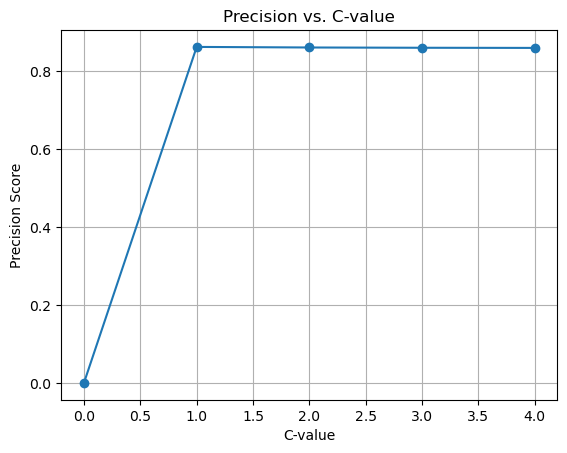

In [37]:
import matplotlib.pyplot as plt

# Plotting the line graph
plt.plot(precisions.index, precisions.values, marker='o', linestyle='-')
plt.title('Precision vs. C-value')
plt.xlabel('C-value')
plt.ylabel('Precision Score')
plt.grid(True)
plt.show()

In [39]:
# Example but won't work with this code
results = []
for y in predictions_df:
    results.append(f1_score(y_test_man, y))

ValueError: Found input variables with inconsistent numbers of samples: [3000, 13]

# 4. Activity 

- Read the documentation here to initialize a ridge regression (l2 penalty)- you can use the same cost parameter (C) and number of iterations as in the lasso example above: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- Fit the model on X_train_man, y_train_main 
- Generate binary and continuous predictions
- Create a function that takes in a dataframe of binary predictions and true labels and manually calculates the $F_{1}$ score:

$$F_{1} = 2 * \dfrac{precision * recall}{precision + recall} = \dfrac{TP}{TP + 0.5(FP + FN)}$$

- Apply that function to calculate the F1 score for the decision tree and lasso (from above), and ridge regression (from the activity)
- *Challenge exercise*: parametrize the model fitting with a function that takes in a classifier as an argument and returns coefficients or feature importances and certain eval metrics (eg precision, recall, and F1)

In [44]:
logit_ridge = LogisticRegression(penalty = "l2",max_iter=100, 
             C = 0.01, solver='liblinear')
logit_ridge.fit(X_train_man[[col for col in X_train.columns if col not in 
                   non_feat]], y_train_man)

LogisticRegression(C=0.01, solver='liblinear')

In [41]:
y_pred = logit_ridge.predict(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])
y_predprob = logit_ridge.predict_proba(X_test_man[[col for col 
                in X_test_man.columns if col not in non_feat]])

In [42]:
## make into a dataframe
y_pred_df = pd.DataFrame({'y_pred_binary': y_pred,
                         'y_pred_continuous': [one_prob[1] 
                                            for one_prob in y_predprob],
                         'y_true': y_test_man})
y_pred_df.sample(n = 10, random_state = 4484)


,y_pred_binary,y_pred_continuous,y_true
656,0,0.087789,0
825,1,0.720484,1
1641,1,0.847071,1
2249,1,0.704340,1
1080,0,0.410711,0
2490,1,0.620160,1
2857,1,0.693145,1
1160,1,0.712472,1
1061,1,0.575025,0
2255,0,0.100325,0


In [50]:
def calculate_f1_score(df):
    y_pred_binary = df['y_pred_binary']
    y_true = df['y_true']
    return f1_score(y_true, y_pred_binary)

calculate_f1_score(y_pred_df)
calculate_f1_score(predictions_df[predictions_df['C_value'] == 4])

0.8706866504008364

0.8686868686868688